In [1]:
!pip install optuna

# **Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_1samp
from statsmodels.graphics.tsaplots import plot_acf
import itertools
import requests
import optuna
import logging
import warnings
import shap
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)
warnings.simplefilter("ignore")
logger = logging.getLogger("optuna")
logger.setLevel(logging.WARNING)

# **Data Collecting**

Stock data is retrieved through the Moscow Exchange API [MOEX API](https://www.moex.com/a2193). We analyze stocks that were part of the MOEX index as of December 3, 2024, sourced from [SberCIB](https://sbercib.ru/publication/birzhevye-indeksy-mosbirzhi). The dataset spans from April 1, 2022, to December 31, 2024.

The MOEX index stocks are chosen because:

*  They are highly liquid, ensuring more stable price movements.

*  They have a significant impact on the overall market trend.

*  They offer a representative sample of the Russian stock market, allowing for robust backtesting.

In [3]:
# API parameters
engine = 'stock'
market = 'shares'
board = 'TQBR'
start_date = '2022-04-01'
end_date = '2024-12-31'

# Composition of the IMOEX according to https://sbercib.ru/publication/birzhevye-indeksy-mosbirzhi
tickers = [
    'AFKS', 'AFLT', 'ALRS', 'ASTR', 'BSPB', 'CBOM', 'CHMF', 'ENPG', 'FEES',
    'FLOT', 'GAZP', 'GMKN', 'HEAD', 'HYDR', 'IRAO', 'LEAS', 'LKOH', 'MAGN',
    'MGNT', 'MOEX', 'MSNG', 'MTLR', 'MTLRP', 'MTSS', 'NLMK', 'NVTK', 'PHOR',
    'PIKK', 'PLZL', 'POSI', 'ROSN', 'RTKM', 'RUAL', 'SBER', 'SBERP', 'SELG',
    'SMLT', 'SNGS', 'SNGSP', 'SVCB', 'T', 'TATN', 'TATNP', 'TRNFP', 'UGLD',
    'UPRO', 'VKCO', 'VTBR', 'YDEX'
]

# Function to parse the data
def fetch_data(ticker):
    url = f"https://iss.moex.com/iss/history/engines/{engine}/markets/{market}/boards/{board}/securities/{ticker}.json"
    all_data = []
    start = 0

    expected_columns = ['SECID', 'TRADEDATE', 'WAPRICE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VOLUME']

    while True:
        params = {
            'from': start_date,
            'till': end_date,
            'start': start
        }
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Failed to fetch data for {ticker}: {response.status_code}")
            break

        json_data = response.json()
        history = json_data.get('history', {})
        data = history.get('data', [])
        columns = history.get('columns', [])

        if not data:
            break

        df = pd.DataFrame(data, columns=columns)

        df = df.reindex(columns=expected_columns).dropna(how='all')

        if not df.empty:
            all_data.append(df)
            start += len(data)
        else:
            break

    if all_data:

        dtypes = {
            'SECID': 'str',
            'TRADEDATE': 'str',
            'WAPRICE': 'float64',
            'OPEN': 'float64',
            'CLOSE': 'float64',
            'LOW': 'float64',
            'HIGH': 'float64',
            'VOLUME': 'int64'
        }
        return pd.concat(all_data, ignore_index=True).astype(dtypes)
    else:
        return pd.DataFrame()

results = {}
for ticker in tickers:
    data = fetch_data(ticker)
    if not data.empty:
        results[ticker] = data

### **Check the quality of the parsed data**

The dataset is examined for missing values, focusing on essential columns:

```'TRADEDATE', 'OPEN', 'CLOSE', 'WAPRICE', 'LOW', 'HIGH', 'VOLUME'```. Only 37 out of 49 stocks had complete data, so we use only these for simplicity and robustness.

In [4]:
start_date = "2022-04-01" # First trading date in the time period
end_date = "2024-12-30" # Last trading date in the time period

empty_dataframes = []
partial_dataframes = []
full_dataframes = []

columns_to_check = ['TRADEDATE', 'OPEN', 'CLOSE', 'WAPRICE', 'LOW', 'HIGH', 'VOLUME']

for ticker, df in results.items():

    if df.empty or df.isnull().all().all():
        empty_dataframes.append(ticker)
        continue

    if 'TRADEDATE' in df.columns:
        df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'], errors='coerce')
    else:
        partial_dataframes.append(ticker)
        continue

    if df[columns_to_check].isnull().any().any():
        partial_dataframes.append(ticker)
        continue

    if df['TRADEDATE'].min() > pd.to_datetime(start_date) or df['TRADEDATE'].max() < pd.to_datetime(end_date):
        partial_dataframes.append(ticker)
    else:
        full_dataframes.append(ticker)

print(f"Empty dataframes ({len(empty_dataframes)}): {empty_dataframes}")
print(f"Partial dataframes ({len(partial_dataframes)}): {partial_dataframes}")
print(f"Full dataframes ({len(full_dataframes)}): {full_dataframes}")

Empty dataframes (0): []
Partial dataframes (12): ['ASTR', 'FEES', 'GMKN', 'HEAD', 'LEAS', 'SVCB', 'T', 'TRNFP', 'UGLD', 'VKCO', 'VTBR', 'YDEX']
Full dataframes (37): ['AFKS', 'AFLT', 'ALRS', 'BSPB', 'CBOM', 'CHMF', 'ENPG', 'FLOT', 'GAZP', 'HYDR', 'IRAO', 'LKOH', 'MAGN', 'MGNT', 'MOEX', 'MSNG', 'MTLR', 'MTLRP', 'MTSS', 'NLMK', 'NVTK', 'PHOR', 'PIKK', 'PLZL', 'POSI', 'ROSN', 'RTKM', 'RUAL', 'SBER', 'SBERP', 'SELG', 'SMLT', 'SNGS', 'SNGSP', 'TATN', 'TATNP', 'UPRO']


In purpose of simplicitly we will use only tickers with full data. We have got 37 stocks that meet the requirements.

In [5]:
"""
'AFKS', 'AFLT', 'ALRS', 'BSPB', 'CBOM', 'CHMF', 'ENPG', 'FLOT', 'GAZP', 'HYDR',
'IRAO', 'LKOH', 'MAGN', 'MGNT', 'MOEX', 'MSNG', 'MTLR', 'MTLRP', 'MTSS', 'NLMK',
'NVTK', 'PHOR', 'PIKK', 'PLZL', 'POSI', 'ROSN', 'RTKM', 'RUAL', 'SBER', 'SBERP',
'SELG', 'SMLT', 'SNGS', 'SNGSP', 'TATN', 'TATNP', 'UPRO'
"""

rest_tickers = full_dataframes
stocks = {}

for ticker in rest_tickers:
  stocks[ticker] = results[ticker]

# **Data preprocessing**

### **Dividend and split policy**

To ensure accurate historical returns, we incorporate dividend payouts and stock splits, retrieved from [Finrange](https://finrange.com/ru/company/MOEX) and [Investing.com](https://ru.investing.com/stock-split-calendar/), as well as the ```dividends_splits.csv file```.




In [6]:
corporate_actions = {
    "AFKS": [
        {"type": "dividend", "date": "2023-07-19", "value": 0.41},
        {"type": "dividend", "date": "2024-07-17", "value": 0.52}
    ],
    "ALRS": [
        {"type": "dividend", "date": "2023-10-18", "value": 3.77},
        {"type": "dividend", "date": "2024-05-31", "value": 2.02},
        {"type": "dividend", "date": "2024-10-19", "value": 2.49}
    ],
    "ASTR": [
        {"type": "dividend", "date": "2024-07-09", "value": 7.89}
    ],
    "BSPB": [
        {"type": "dividend", "date": "2022-08-29", "value": 11.81},
        {"type": "dividend", "date": "2023-05-10", "value": 21.16},
        {"type": "dividend", "date": "2023-10-09", "value": 19.08},
        {"type": "dividend", "date": "2024-05-06", "value": 23.37},
        {"type": "dividend", "date": "2024-09-30", "value": 27.26}
    ],
    "CHMF": [
        {"type": "dividend", "date": "2024-06-18", "value": 38.30},
        {"type": "dividend", "date": "2024-06-18", "value": 191.51},
        {"type": "dividend", "date": "2024-09-10", "value": 31.06},
        {"type": "dividend", "date": "2024-12-17", "value": 49.06}
    ],
    "FLOT": [
        {"type": "dividend", "date": "2023-07-05", "value": 4.29},
        {"type": "dividend", "date": "2024-01-07", "value": 6.32},
        {"type": "dividend", "date": "2024-07-20", "value": 11.27}
    ],
    "GAZP": [
        {"type": "dividend", "date": "2022-10-11", "value": 51.03}
    ],
    "GMKN": [
        {"type": "dividend", "date": "2022-06-14", "value": 1166.22},
        {"type": "dividend", "date": "2023-12-26", "value": 915.33},
        {"type": "split", "date": "2024-04-04", "ratio": "100:1"}
    ],
    "HYDR": [
        {"type": "dividend", "date": "2023-07-11", "value": 0.05}
    ],
    "IRAO": [
        {"type": "dividend", "date": "2022-06-10", "value": 0.24},
        {"type": "dividend", "date": "2023-05-30", "value": 0.28},
        {"type": "dividend", "date": "2024-06-03", "value": 0.33}
    ],
    "LEAS": [
        {"type": "dividend", "date": "2022-07-04", "value": 16.67},
        {"type": "dividend", "date": "2022-09-02", "value": 12.5},
        {"type": "dividend", "date": "2023-04-19", "value": 16.67},
        {"type": "dividend", "date": "2023-09-19", "value": 12.5},
        {"type": "dividend", "date": "2023-11-18", "value": 19.17},
        {"type": "dividend", "date": "2024-06-11", "value": 25},
        {"type": "dividend", "date": "2024-12-15", "value": 50}
    ],
    "LKOH": [
        {"type": "dividend", "date": "2022-12-21", "value": 256},
        {"type": "dividend", "date": "2022-12-21", "value": 537},
        {"type": "dividend", "date": "2023-06-05", "value": 438},
        {"type": "dividend", "date": "2023-12-17", "value": 447},
        {"type": "dividend", "date": "2024-05-07", "value": 498},
        {"type": "dividend", "date": "2024-12-17", "value": 514}
    ],
    "MAGN": [
        {"type": "dividend", "date": "2022-01-13", "value": 2.66},
        {"type": "dividend", "date": "2024-06-10", "value": 2.75},
        {"type": "dividend", "date": "2024-10-17", "value": 2.49}
    ],
    "MGNT": [
        {"type": "dividend", "date": "2024-01-11", "value": 412.13},
        {"type": "dividend", "date": "2024-07-15", "value": 412.13}
    ],
    "MOEX": [
        {"type": "dividend", "date": "2023-06-16", "value": 4.84},
        {"type": "dividend", "date": "2024-06-14", "value": 17.35}
    ],
    "MSNG": [
        {"type": "dividend", "date": "2022-07-11", "value": 0.22},
        {"type": "dividend", "date": "2023-07-04", "value": 0.19},
        {"type": "dividend", "date": "2024-07-09", "value": 0.16}
    ],
    "MTSS": [
        {"type": "dividend", "date": "2022-07-12", "value": 33.85},
        {"type": "dividend", "date": "2023-06-29", "value": 34.29},
        {"type": "dividend", "date": "2024-07-16", "value": 35.0}
    ],
    "NLMK": [
        {"type": "dividend", "date": "2024-05-27", "value": 25.43}
    ],
    "NVTK": [
        {"type": "dividend", "date": "2022-05-05", "value": 43.77},
        {"type": "dividend", "date": "2022-10-09", "value": 45.0},
        {"type": "dividend", "date": "2023-05-03", "value": 60.58},
        {"type": "dividend", "date": "2023-10-10", "value": 34.5},
        {"type": "dividend", "date": "2024-03-26", "value": 44.09},
        {"type": "dividend", "date": "2024-10-11", "value": 35.5}
    ],
    "PHOR": [
        {"type": "dividend", "date": "2022-10-03", "value": 780},
        {"type": "dividend", "date": "2022-12-19", "value": 318},
        {"type": "dividend", "date": "2023-04-04", "value": 465},
        {"type": "dividend", "date": "2023-07-11", "value": 264},
        {"type": "dividend", "date": "2023-12-25", "value": 291},
        {"type": "dividend", "date": "2024-07-11", "value": 309},
        {"type": "dividend", "date": "2024-07-11", "value": 15},
        {"type": "dividend", "date": "2024-07-11", "value": 294},
        {"type": "dividend", "date": "2024-09-22", "value": 117},
        {"type": "dividend", "date": "2024-12-22", "value": 126}
    ],
    "POSI": [
        {"type": "dividend", "date": "2022-05-08", "value": 14.4},
        {"type": "dividend", "date": "2022-11-14", "value": 5.16},
        {"type": "dividend", "date": "2023-04-16", "value": 37.87},
        {"type": "dividend", "date": "2023-12-03", "value": 15.8},
        {"type": "dividend", "date": "2024-03-26", "value": 47.3},
        {"type": "dividend", "date": "2024-05-24", "value": 4.56}
    ],
    "ROSN": [
        {"type": "dividend", "date": "2022-07-11", "value": 23.63},
        {"type": "dividend", "date": "2023-01-12", "value": 20.39},
        {"type": "dividend", "date": "2023-07-11", "value": 17.97},
        {"type": "dividend", "date": "2024-01-10", "value": 30.77},
        {"type": "dividend", "date": "2024-07-09", "value": 29.01}
    ],
    "RTKM": [
        {"type": "dividend", "date": "2022-07-20", "value": 4.56},
        {"type": "dividend", "date": "2023-12-01", "value": 5.45},
        {"type": "dividend", "date": "2024-09-27", "value": 6.06}
    ],
    "RUAL": [
        {"type": "dividend", "date": "2022-10-20", "value": 1.21}
    ],
    "SBER": [
        {"type": "dividend", "date": "2023-05-11", "value": 25},
        {"type": "dividend", "date": "2024-07-11", "value": 33.30}
    ],
    "SBERP": [
        {"type": "dividend", "date": "2023-05-11", "value": 25},
        {"type": "dividend", "date": "2024-07-11", "value": 33.30}
    ],
    "SELG": [
        {"type": "dividend", "date": "2022-06-21", "value": 4.5},
        {"type": "dividend", "date": "2023-12-03", "value": 2},
        {"type": "dividend", "date": "2024-06-15", "value": 2},
        {"type": "dividend", "date": "2024-10-11", "value": 4}
    ],
    "SMLT": [
        {"type": "dividend", "date": "2022-07-11", "value": 41},
        {"type": "dividend", "date": "2022-10-12", "value": 41}
    ],
    "SNGS": [
        {"type": "dividend", "date": "2022-07-20", "value": 0.8},
        {"type": "dividend", "date": "2023-07-20", "value": 0.8},
        {"type": "dividend", "date": "2024-07-18", "value": 0.85}
    ],
    "SNGSP": [
        {"type": "dividend", "date": "2022-07-20", "value": 4.73},
        {"type": "dividend", "date": "2023-07-20", "value": 0.8},
        {"type": "dividend", "date": "2024-07-18", "value": 12.29}
    ],
    "T": [
        {"type": "dividend", "date": "2024-11-25", "value": 92.5}
    ],
    "TATN": [
        {"type": "dividend", "date": "2022-07-08", "value": 16.14},
        {"type": "dividend", "date": "2022-10-11", "value": 32.71},
        {"type": "dividend", "date": "2023-01-10", "value": 6.86},
        {"type": "dividend", "date": "2023-07-11", "value": 27.71},
        {"type": "dividend", "date": "2023-10-11", "value": 27.54},
        {"type": "dividend", "date": "2024-01-09", "value": 35.17},
        {"type": "dividend", "date": "2024-07-04", "value": 25.17},
        {"type": "dividend", "date": "2024-07-09", "value": 25.17},
        {"type": "dividend", "date": "2024-10-08", "value": 38.20}
    ],
    "TATNP": [
        {"type": "dividend", "date": "2022-07-08", "value": 16.14},
        {"type": "dividend", "date": "2022-10-11", "value": 32.71},
        {"type": "dividend", "date": "2023-01-10", "value": 6.86},
        {"type": "dividend", "date": "2023-07-11", "value": 27.71},
        {"type": "dividend", "date": "2023-10-11", "value": 27.54},
        {"type": "dividend", "date": "2024-01-09", "value": 35.17},
        {"type": "dividend", "date": "2024-07-09", "value": 25.17},
        {"type": "dividend", "date": "2024-10-08", "value": 38.20}
    ],
    "TRNFP": [
        {"type": "dividend", "date": "2023-07-05", "value": 166.65},
        {"type": "dividend", "date": "2024-07-18", "value": 1.77},
        {"type": "split", "date": "2024-02-19", "ratio": "100:1"}
    ],
    "VTBR": [
        {"type": "split", "date": "2024-07-15", "ratio": "1:5000"}
    ],
    "YDEX": [
        {"type": "dividend", "date": "2024-09-20", "value": 80}
    ]
}


### **Calculating adjusted prices**

In [7]:
for ticker in stocks:
    stocks[ticker] = stocks[ticker].set_index('TRADEDATE')
    stocks[ticker].index = pd.to_datetime(stocks[ticker].index)
    stocks[ticker] = stocks[ticker].sort_index()

def calculate_adjusted_price(df, actions):
    df = df.copy()

    df['ADJ_OPEN'] = df['OPEN']
    df['ADJ_CLOSE'] = df['CLOSE']

    sorted_actions = sorted(
        actions,
        key=lambda x: datetime.strptime(x['date'], '%Y-%m-%d')
    )

    for action in sorted_actions:
        action_date = datetime.strptime(action['date'], '%Y-%m-%d')

        mask = df.index < action_date

        if action['type'] == 'dividend':
            # Adjust stock price by dividend
            df.loc[mask, 'ADJ_OPEN'] -= action['value']
            df.loc[mask, 'ADJ_CLOSE'] -= action['value']

        elif action['type'] == 'split':
            numerator, denominator = map(float, action['ratio'].split(':'))
            ratio = numerator / denominator

            # Adjust stock price by split
            df.loc[mask, 'ADJ_OPEN'] /= ratio
            df.loc[mask, 'ADJ_CLOSE'] /= ratio

    return df

for ticker in stocks:

    if ticker in corporate_actions:

        stocks[ticker] = calculate_adjusted_price(stocks[ticker], corporate_actions[ticker])
    else:

        stocks[ticker]['ADJ_OPEN'] = stocks[ticker]['OPEN']
        stocks[ticker]['ADJ_CLOSE'] = stocks[ticker]['CLOSE']

    stocks[ticker] = stocks[ticker].sort_index()

### **In-Sample and OSplittingut-of-Sample**

We divide the dataset into:

*   **In-Sample (Train + Validation):** Used for optimizing strategy parameters.

*  **Out-of-Sample (Test):** Used to evaluate final strategy performance and mitigate overfitting.

Additionally, the in-sample data is split into **train (60%)** and **validation (20%)** to optimize hyperparameters for machine learning models. The remaining **20% is used for testing.**

In [8]:
def split_data_periods(data, train_ratio=0.6, val_ratio=0.2):
    dates = data['AFKS'].index.sort_values()

    n = len(dates)
    train_end_idx = int(n * train_ratio)
    val_end_idx = train_end_idx + int(n * val_ratio)

    train_start = dates[0]
    train_end = dates[train_end_idx - 1]

    val_start = dates[train_end_idx]
    val_end = dates[val_end_idx - 1]

    test_start = dates[val_end_idx]
    test_end = dates[-1]

    return {
        'train': {'start': train_start.strftime('%Y-%m-%d'),
                 'end': train_end.strftime('%Y-%m-%d')},
        'validation': {'start': val_start.strftime('%Y-%m-%d'),
                      'end': val_end.strftime('%Y-%m-%d')},
        'test': {'start': test_start.strftime('%Y-%m-%d'),
                'end': test_end.strftime('%Y-%m-%d')}
    }

periods = split_data_periods(stocks)

print("Train period:", periods['train'])
print("Validation period:", periods['validation'])
print("Test period:", periods['test'])

Train period: {'start': '2022-04-01', 'end': '2023-11-27'}
Validation period: {'start': '2023-11-28', 'end': '2024-06-18'}
Test period: {'start': '2024-06-19', 'end': '2024-12-30'}


# **Risk-free rate**


For benchmarking, we use Russian **3-month zero-coupon bonds** from MOEX [Risk-Free Rates](https://www.moex.com/ru/marketdata/indices/state/g-curve/archive/) found in ```risk_free_rates.csv```. The annualized risk-free rate is converted into a daily rate using **continuous compounding:**

$$r_{daily} = \frac{\ln(1+r_{annual})}{252}$$


Additionally, we use **30-year zero-coupon bonds** to compute the **term spread**, which serves as a potential feature for ML models.




In [9]:
risk_free = pd.read_csv("risk_free_rates.csv", index_col = 0, delimiter = ';', parse_dates=True)
risk_free.index = pd.to_datetime(risk_free.index, dayfirst = True)
risk_free["period_0.25"] = risk_free["period_0.25"].str.replace(",", ".").astype(float)
risk_free["period_30.0"] = risk_free["period_30.0"].str.replace(",", ".").astype(float)

risk_free = risk_free.loc['2022-04-01':'2024-12-31']

risk_free["daily_risk_free"] = np.log(1 + risk_free["period_0.25"] / 100) / 252
risk_free["term_spread"] = risk_free["period_30.0"] - risk_free["period_0.25"]
risk_free["term_spread_day_freq"] = np.log(1 + risk_free["term_spread"] / 100) / 252

# Perfomance on out-of-sample
risk_free.loc[:,"total_returns"] = 0.0
risk_free.loc[:,"test_daily_risk_free"] = 0.0

risk_free.loc['2024-06-19':'2024-12-30', "test_daily_risk_free"] = risk_free.loc['2024-06-19':'2024-12-30', "daily_risk_free"]
risk_free.loc['2024-06-19':'2024-12-30', "total_returns"] = (1 + risk_free["test_daily_risk_free"]).cumprod()

risk_free.head()

,tradetime,period_0.25,period_30.0,daily_risk_free,term_spread,term_spread_day_freq,total_returns,test_daily_risk_free
tradedate,,,,,,,,
2022-04-01,18:39:56,15.06,11.19,0.000557,-3.87,-0.000157,0.0,0.0
2022-04-04,18:39:59,15.55,11.61,0.000574,-3.94,-0.000160,0.0,0.0
2022-04-05,18:39:59,15.28,11.61,0.000564,-3.67,-0.000148,0.0,0.0
2022-04-06,18:39:57,15.22,11.93,0.000562,-3.29,-0.000133,0.0,0.0
2022-04-07,18:39:53,15.09,11.78,0.000558,-3.31,-0.000134,0.0,0.0


# **Buy and hold strategy**




This strategy constructs an **equally weighted portfolio** of all selected stocks. The portfolio is bought on the first day and held until the end.

**Why Consider Buy-and-Hold?**

*  It provides a baseline comparison against more complex strategies.

*  It reflects overall market trends over the given period.

*  It is widely used by long-term investors.

Metrics of interest include:

*  **Daily Sharpe Ratio**

*  **t-statistic for daily returns**, which helps assess whether returns are significantly greater than zero.

The **t-statistic** is used to determine whether the daily returns are statistically different from zero, helping to measure the robustness of excess returns.

In [10]:
def backtest_buy_and_hold(data, start_date, end_date):
  portfolio_daily_returns = pd.DataFrame()
  portfolio_total_returns = pd.DataFrame()

  for ticker, df in data.items():
    df_period = df.loc[start_date:end_date].copy()

    buy_price = df_period.iloc[0]['ADJ_CLOSE']

    df_period['total_return'] = df_period['ADJ_CLOSE'] / buy_price
    df_period['daily_return'] = df_period['total_return'].pct_change()

    portfolio_daily_returns[ticker] = df_period['daily_return']
    portfolio_total_returns[ticker] = df_period['total_return']

  portfolio_daily_returns = portfolio_daily_returns.fillna(0)

  daily_returns = portfolio_daily_returns.mean(axis=1).values # Equally weighted portfolio
  daily_returns_df = portfolio_daily_returns.mean(axis=1)

  total_returns = portfolio_total_returns.mean(axis=1).values
  total_returns_df = portfolio_total_returns.mean(axis=1)

  avg_daily_return = daily_returns.mean()
  std_daily_return = daily_returns.std()

  sharpe_ratio = (avg_daily_return - risk_free.loc[start_date:end_date]['daily_risk_free'].values.mean())/ std_daily_return

  t_stat, p_value = ttest_1samp(daily_returns, 0, alternative='greater')

  return {
      "total_returns": total_returns_df,
      "daily_returns": daily_returns_df,
      "sharpe_ratio": sharpe_ratio,
      "t_statistic": t_stat
  }

**In-sample results**

In [11]:
in_sample_bah = backtest_buy_and_hold(stocks, "2022-04-01", "2024-06-18")

print(f"In-sample Daily Sharpe Ratio: {in_sample_bah['sharpe_ratio']:.4f}, t-statistic ({in_sample_bah['t_statistic']:.2f})")

In-sample Daily Sharpe Ratio: -0.0242, t-statistic (-0.29)


**Out-of-sample results**

In [12]:
out_of_sample_bah = backtest_buy_and_hold(stocks, "2024-06-19", "2024-12-30")

print(f"Out-of-sample Daily Sharpe Ratio: {out_of_sample_bah['sharpe_ratio']:.4f}, t-statistic ({out_of_sample_bah['t_statistic']:.2f})")

Out-of-sample Daily Sharpe Ratio: -0.0633, t-statistic (-0.32)


# **Buy winners - sell losers strategy**


Based on **"Returns to Buying Winners and Selling Losers"** (Jegadeesh & Titman, *Journal of Finance*, 1993), adapted to the Russian stock market.

**Momentum Selection (J days)**: Stocks with the highest returns are bought, while those with the lowest returns are shorted, forming a **zero-cost portfolio**.

**Holding Period (K days)**: The portfolio is held for K days before rebalancing.

This strategy exploits **momentum**—the idea that stocks with strong past performance tend to continue performing well in the short term.

During **in-sample tuning**, optimal values of **J and K** (ranging from 1 to 10) are determined. **Out-of-sample data** is used to validate returns.

In [13]:
def calculate_returns(data, J):
    """Calculate J-period returns"""
    returns_data = {}
    for ticker, df in data.items():
        df["J_return"] = df["ADJ_CLOSE"].pct_change(J).shift(1)
        returns_data[ticker] = df.dropna(subset=["J_return"])
    return returns_data

def form_portfolio(returns_df, decile=0.1):
    """Form portfolio based on the past returns"""

    sorted_df = returns_df.sort_values("J_return")

    n_select = max(1, int(len(sorted_df) * decile))

    return {
        "long": sorted_df.tail(n_select).index.tolist(),  # Higher decile
        "short": sorted_df.head(n_select).index.tolist()  # Lower decile
    }

def backtest_bwsl_strategy(data, start_date, end_date, J=1, K=1, decile=0.1):

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    returns_data = calculate_returns(data, J)

    all_dates = returns_data['AFKS'].index
    all_dates = all_dates[(all_dates >= start_date) & (all_dates <= end_date)]

    portfolio_returns = pd.Series(0.0, index=all_dates)
    total_returns = pd.Series(1.0, index=all_dates)
    current_total = 1.0

    positions = []

    for current_date in all_dates:

        daily_return = 0.0
        new_positions = []

        # Close position
        for pos in positions:
            exit_date = pos["exit_date"]
            if exit_date == current_date:
                ticker = pos["ticker"]
                entry_date =pos["entry_date"]

                try:
                    entry_price = data[ticker].loc[entry_date, "ADJ_OPEN"]
                    exit_price = data[ticker].loc[current_date, "ADJ_CLOSE"]
                    ret = (exit_price - entry_price)/entry_price * pos["weight"]
                    daily_return += ret
                except KeyError:
                    continue
            else:
                new_positions.append(pos)

        positions = new_positions
        portfolio_returns.loc[current_date] = daily_return

        current_total *= (1 + daily_return)
        total_returns.loc[current_date] = current_total

        # Open position
        if all_dates.get_loc(current_date) + K >= len(all_dates):
            continue

        formation_data = {}
        for ticker, df in returns_data.items():
            current_date = pd.to_datetime(current_date)
            if current_date in df.index:
                formation_data[ticker] = df.loc[:current_date, "J_return"].iloc[-1]

        formation_df = pd.DataFrame.from_dict(formation_data, orient='index', columns=["J_return"]).dropna()

        portfolio = form_portfolio(formation_df, decile)

        # Calculate weights of the positions
        total = len(portfolio["long"]) + len(portfolio["short"])
        weight = 1 / total

        exit_date = all_dates[all_dates.get_loc(current_date) + K]
        for ticker in portfolio["long"]:
            positions.append({
                "ticker": ticker,
                "entry_date": current_date,
                "exit_date": exit_date,
                "weight": weight
            })

        for ticker in portfolio["short"]:
            positions.append({
                "ticker": ticker,
                "entry_date": current_date,
                "exit_date": exit_date,
                "weight": -weight
            })

    daily_returns = portfolio_returns.replace(0, np.nan).dropna()

    sharpe = (daily_returns.mean() - risk_free.loc[start_date:end_date]['daily_risk_free'].values.mean())/ daily_returns.std()
    t_stat, _ = ttest_1samp(daily_returns, 0, alternative="greater")

    return {
        "daily_returns": portfolio_returns,
        'total_returns': total_returns,
        "sharpe_ratio": sharpe,
        "t_statistic": t_stat
    }

**Optimal hyperparameters calibration**

In [14]:
def optimize_hyperparameters(data, start_date, end_date, decile=0.1):
    best_sharpe = -np.inf
    best_params = {'J': None, 'K': None}
    results = []

    params_grid = itertools.product(range(1, 11), range(1, 11))  # J and K ranges

    for J, K in params_grid:
        try:
            result = backtest_bwsl_strategy(data, start_date, end_date, J, K, decile)

            results.append({'J': J, 'K': K, 'sharpe_ratio': result['sharpe_ratio'], 't_statistic': result['t_statistic']})

            if result['sharpe_ratio'] > best_sharpe:
                best_sharpe = result['sharpe_ratio']
                best_params['J'] = J
                best_params['K'] = K

        except Exception as e:
            print(f"Error for J={J}, K={K}: {str(e)}")
            continue

    results_df = pd.DataFrame(results)

    return best_params, results_df

def plot_heatmaps(results_df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 14))

    # Sharpe Ratio heatmap
    sharpe_heatmap = results_df.pivot(index='J', columns='K', values='sharpe_ratio')
    sns.heatmap(sharpe_heatmap, annot=True, fmt=".2f", cmap='coolwarm', center=0, ax=ax1, cbar_kws={'label': 'Sharpe Ratio'})
    ax1.set_title('Daily Sharpe Ratio')
    ax1.set_xlabel('K (Holding period)')
    ax1.set_ylabel('J (Assessing period)')

    # t-stat heatmap
    tstat_heatmap = results_df.pivot(index='J', columns='K', values='t_statistic')
    sns.heatmap(tstat_heatmap, annot=True, fmt=".1f", cmap='viridis', ax=ax2, cbar_kws={'label': 't-Statistic'})
    ax2.set_title('Corresponding Statistical significance  (t-statistic)')
    ax2.set_xlabel('K (Holding period)')
    ax2.set_ylabel('J (Assessing period)')

    plt.tight_layout()
    plt.show()

**In-sample results**

Best hyperparameters: J=7, K=8
Highest Daily Sharpe Ratio: 0.1444, t-statistic (3.41)


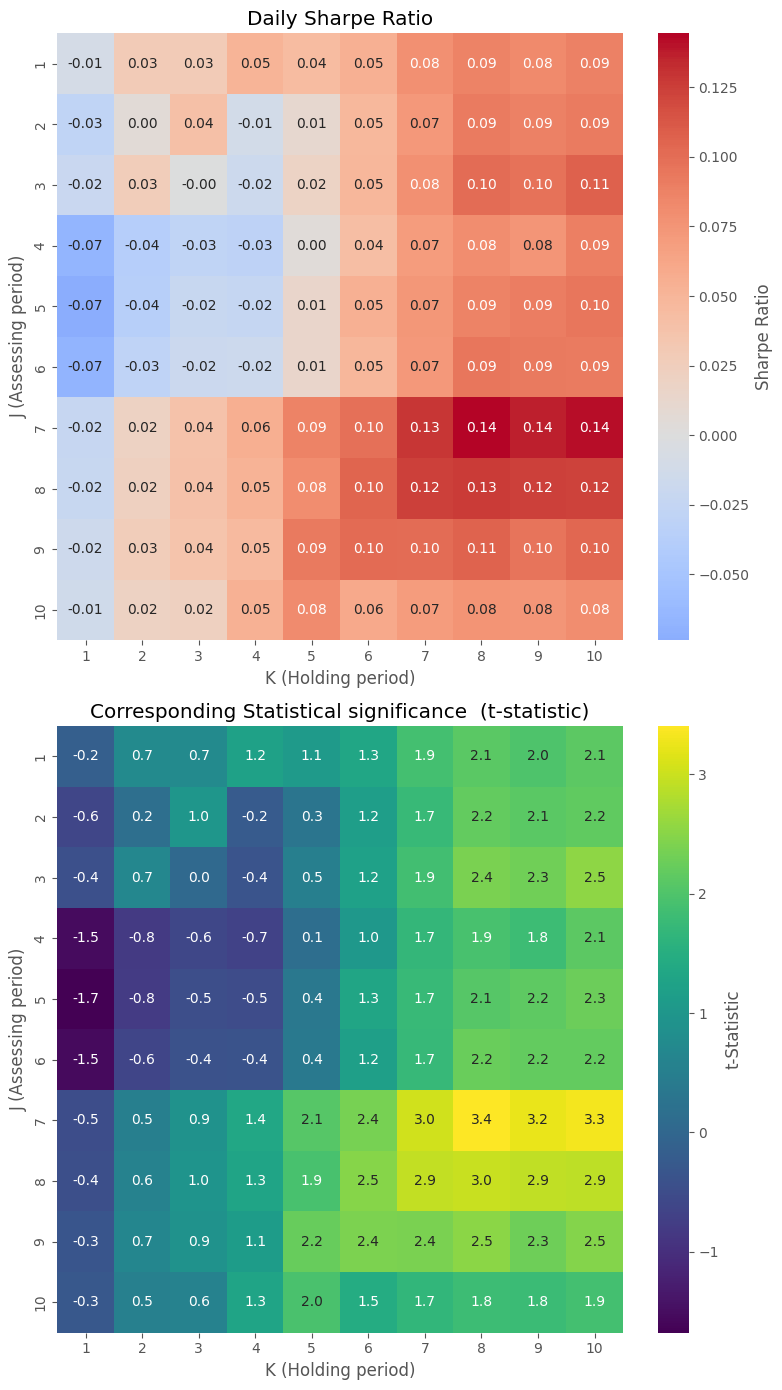

In [15]:
bwsl_best_params, in_sample_bwsl_calibration = optimize_hyperparameters(stocks, start_date="2022-04-01", end_date="2024-06-18", decile=0.1)

print(f"Best hyperparameters: J={bwsl_best_params['J']}, K={bwsl_best_params['K']}")
print(f"Highest Daily Sharpe Ratio: {in_sample_bwsl_calibration['sharpe_ratio'].max():.4f}, t-statistic ({in_sample_bwsl_calibration.loc[in_sample_bwsl_calibration['sharpe_ratio'].idxmax(), 't_statistic']:.2f})")

plot_heatmaps(in_sample_bwsl_calibration)

**Out-of-sample results**

In [16]:
out_of_sample_bwsl = backtest_bwsl_strategy(stocks, start_date='2024-06-19', end_date='2024-12-30', J=bwsl_best_params['J'], K=bwsl_best_params['K'], decile=0.1)

print(f"Out-of-sample Daily Sharpe Ratio: {out_of_sample_bwsl['sharpe_ratio']:.4f}, t-statistic ({out_of_sample_bwsl['t_statistic']:.2f})")

Out-of-sample Daily Sharpe Ratio: 0.1390, t-statistic (1.89)


# **RSI Momentum strategy**

---



**The Relative Strength Index (RSI)** is a momentum oscillator that measures speed and change of price movements.

**Strategy Rules**:

*  **Go long** if RSI > 70 (indicating overbought conditions, suggesting further price increases).

*  **Go short** if RSI < 30 (indicating oversold conditions, suggesting further price drops).

*  **Exit long** if price exceeds entry price or a short signal appears.

*  **Exit short** if price falls below entry price or a long signal appears.

Why use **30** and **70** as RSI thresholds?

These are standard values widely used in technical analysis.

We apply them across multiple stocks for consistency and robustness.

In [17]:
def calculate_rsi(df, window=10):
    """Calculate RSI (Relative Strength Index)"""
    delta = df['ADJ_CLOSE'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def backtest_rsi_strategy(data, start_date, end_date, upper, lower):

    daily_returns = []
    total_returns = []

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    for ticker in data:
        df = data[ticker].copy()
        df = calculate_rsi(df)
        data[ticker] = df

    all_dates = data['AFKS'].index

    all_dates = all_dates[(all_dates >= start_date) & (all_dates <= end_date)]

    positions = {}  # {ticker: {'type': 'long/short', 'price': float}}
    portfolio_value = 1.0

    for current_date in all_dates:
        daily_return = 0.0
        new_positions = {}

        for ticker in list(positions.keys()):
            pos = positions[ticker]
            df = data[ticker]

            current_price = df.loc[current_date, 'ADJ_CLOSE']

            # CLose position
            if pos['type'] == 'long':
                if current_price > pos['price'] or should_short(data[ticker], current_date, lower):
                    daily_return += (current_price - pos['price']) / pos['price']
                    del positions[ticker]

            elif pos['type'] == 'short':
                if current_price < pos['price'] or should_long(data[ticker], current_date, upper):
                    daily_return += (pos['price'] - current_price) / pos['price']
                    del positions[ticker]

        # Open position
        for ticker, df in data.items():

            prev_date = df.index[df.index < current_date][-1] if any(df.index < current_date) else None
            if prev_date is None:
                continue

            rsi = df.loc[prev_date, 'RSI']

            # Signals
            if rsi > upper and ticker not in positions:
                # Long position
                entry_price = df.loc[current_date, 'ADJ_OPEN']
                new_positions[ticker] = {'type': 'long', 'price': entry_price}

            elif rsi < lower and ticker not in positions:
                # Short position
                entry_price = df.loc[current_date, 'ADJ_OPEN']
                new_positions[ticker] = {'type': 'short', 'price': entry_price}

        positions.update(new_positions)

        n_positions = len(positions)
        if n_positions > 0:
            daily_return /= n_positions  # Equally-weighted portfolio

        portfolio_value *= (1 + daily_return)

        daily_returns.append(daily_return)
        total_returns.append(portfolio_value)

    daily_returns = pd.Series(daily_returns, index=all_dates)
    total_returns = pd.Series(total_returns, index=all_dates)
    sharpe = (daily_returns.mean() - risk_free.loc[start_date:end_date]['daily_risk_free'].values.mean()) / daily_returns.std()
    t_statistic, _ = ttest_1samp(daily_returns, 0, alternative='greater')

    results = {
        'daily_returns': daily_returns,
        'total_returns': total_returns,
        'sharpe_ratio': sharpe,
        't_statistic': t_statistic
    }

    return results

def should_long(df, current_date, upper):
    """Check long closing condition"""
    prev_date = df.index[df.index < current_date][-1] if any(df.index < current_date) else None
    return df.loc[prev_date, 'RSI'] > upper if prev_date else False

def should_short(df, current_date, lower):
    """Check short closing condition"""
    prev_date = df.index[df.index < current_date][-1] if any(df.index < current_date) else None
    return df.loc[prev_date, 'RSI'] < lower if prev_date else False

**In-sample results**


In [18]:
in_sample_rsi = backtest_rsi_strategy(stocks, start_date='2022-04-01', end_date='2024-06-18', upper=70, lower=30)

print(f"In-sample Sharpe: {in_sample_rsi['sharpe_ratio']:.4f}, t-statistic ({in_sample_rsi['t_statistic']:.2f})")

In-sample Sharpe: 0.1683, t-statistic (4.79)


**Out-of-sample results**

In [19]:
out_of_sample_rsi = backtest_rsi_strategy(stocks, start_date='2024-06-19', end_date='2024-12-30', upper=70, lower=30)

print(f"Out-of-sample Sharpe: {out_of_sample_rsi['sharpe_ratio']:.4f}, t-statistic ({out_of_sample_rsi['t_statistic']:.2f})")

Out-of-sample Sharpe: 0.2594, t-statistic (3.99)


# **Machine Learning-Based Strategies**

ML models can capture **non-linear relationships** and **detect patterns** in stock price movements.

We use **Random Forest (RF)** and **Support Vector Regression (SVR)**.

Models predict **price direction**:

*  **Long** if previous and current predictions indicate an increase.

*  **Short** if previous and current predictions indicate a decrease.

## **Feature Engineering**

We engineer features such as:

**Lagged returns (last 3 days)** to capture autocorrelation patterns.

**Seasonality (5-day window)** for business day cycles.

**Rolling statistics (mean, standard deviation)** to track price trends.

**Risk-free rate and term spread** to reflect macroeconomic conditions.

**Dividend payments** to assess market reactions.

To prevent **data leakage**, all features are correctly shifted.

In [20]:
for ticker, df in stocks.items():
  stocks[ticker] = df.drop(columns = ['J_return'])

ml_data = stocks.copy()

**Looking for the most important lags and seasonal patterns**

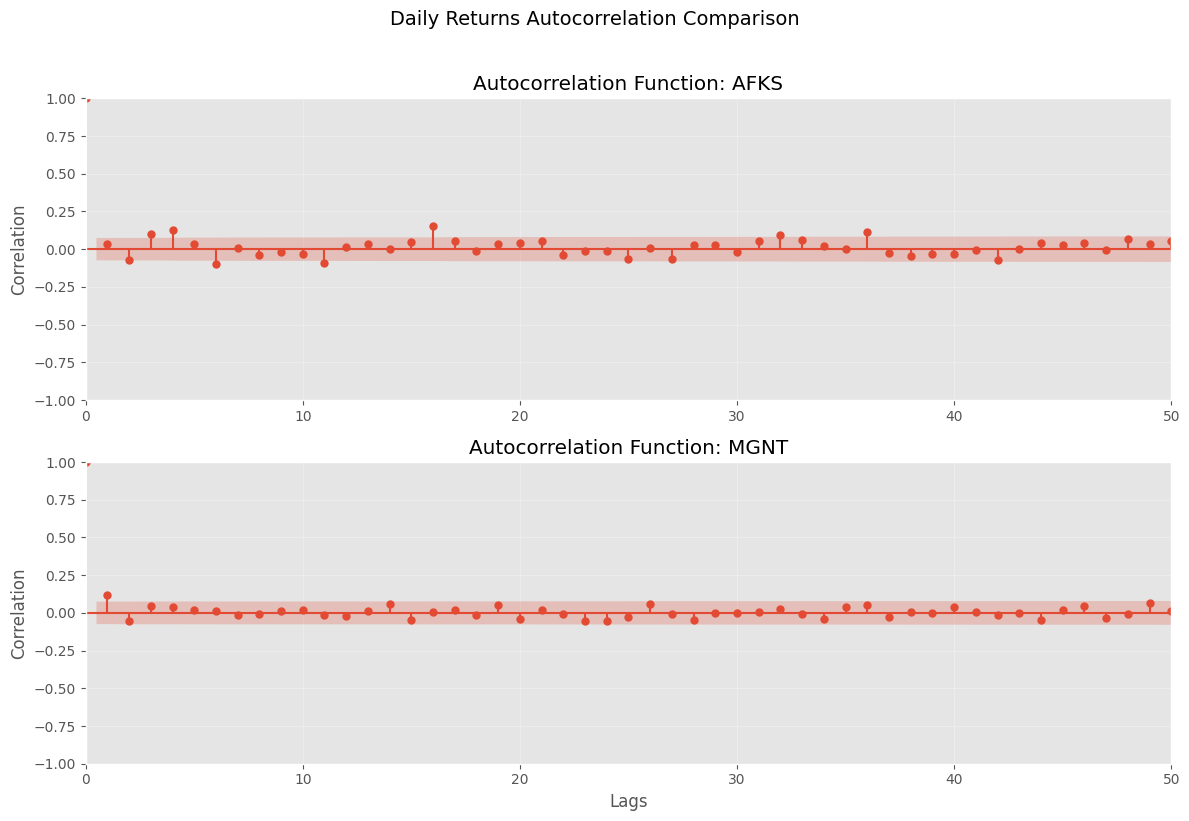

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(ml_data['AFKS']['ADJ_CLOSE'].diff().dropna(),
         lags=50,
         ax=ax1,
         title='Autocorrelation Function: AFKS',
         )
ax1.set_xlim(0, 50)
ax1.grid(alpha=0.3)
ax1.set_ylabel('Correlation')

plot_acf(ml_data['MGNT']['ADJ_CLOSE'].diff().dropna(),
         lags=50,
         ax=ax2,
         title='Autocorrelation Function: MGNT',
         )
ax2.set_xlim(0, 50)
ax2.grid(alpha=0.3)
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

plt.suptitle('Daily Returns Autocorrelation Comparison', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
for ticker, df in ml_data.items():

  # Lags
  df['y_L1'] = df['ADJ_CLOSE'].shift(1)
  df['y_L2'] = df['ADJ_CLOSE'].shift(2)
  df['y_L3'] = df['ADJ_CLOSE'].shift(3)

  # Stock's metric to define momentum
  df['RSI_known'] = df['RSI'].shift(1)
  df['WAPRICE_known'] = df['WAPRICE'].shift(1)
  df['ADJ_OPEN_known'] = df['ADJ_OPEN'].shift(1)
  df['LOW_known'] = df['LOW'].shift(1)
  df['HIGH_known'] = df['HIGH'].shift(1)
  df['VOLUME_known'] = df['VOLUME'].shift(1)
  df['ROC_known'] = df['ADJ_CLOSE'].pct_change(periods=7).shift(1)

  # Rolling statistics
  df['MA_5'] = df['ADJ_CLOSE'].rolling(window = 5).mean().shift(1)
  df['MA_15'] = df['ADJ_CLOSE'].rolling(window = 15).mean().shift(1)
  df['Mstd_5'] = df['ADJ_CLOSE'].rolling(window = 5).std().shift(1)

  # Calendar features
  df['day'] = df.index.dayofweek
  df['sin_5'] = np.sin(2 * np.pi * df['day'] / 5)
  df['cos_5'] = np.cos(2 * np.pi * df['day'] / 5)

  #Interest rates features
  df['daily_risk_free'] = risk_free['daily_risk_free'].shift(1)
  df['term_spread_day_freq'] = risk_free['term_spread_day_freq'].shift(1)

  df = df.dropna()

  ml_data[ticker] = df

In [23]:
# Add dividends as a feature
for ticker in ml_data:
    df = ml_data[ticker]
    df.loc[:,'dividend'] = 0.0

    if ticker in corporate_actions:
        dividends = [
            {
                'date': pd.to_datetime(action['date']),
                'value': action['value']
            }
            for action in corporate_actions[ticker]
            if action['type'] == 'dividend'
        ]

        div_df = pd.DataFrame(dividends)

        if not div_df.empty:
            div_df = div_df.groupby('date')['value'].sum().reset_index()

            df = df.merge(
                div_df,
                left_index=True,
                right_on='date',
                how='left'
            ).set_index(df.index)

            df['dividend'] = df['value'].fillna(0)
            df.drop(columns=['value'], inplace=True)

    ml_data[ticker] = df

# **Random Forest**

In [24]:
train_start, train_end = "2022-04-22", "2023-11-27"
val_start, val_end = "2023-11-28", "2024-06-18"
test_start, test_end = "2024-06-19", "2024-12-30"

features = [
    "y_L1", "y_L2", "y_L3", "RSI_known", "WAPRICE_known", "ADJ_OPEN_known",
    "LOW_known", "HIGH_known", "VOLUME_known", "ROC_known", "MA_5", "MA_15",
    "Mstd_5", "day", "sin_5", "cos_5", "daily_risk_free",
    "term_spread_day_freq", "dividend"
]
target = "ADJ_CLOSE"

total_daily_returns_RF = pd.DataFrame()

test_mses_RF = []
best_params_RF = {}

# In-sample calibration
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_val_pred)

for ticker, df in ml_data.items():
    df = df.copy()

    df_train = df.loc[train_start:train_end]
    df_val = df.loc[val_start:val_end]
    df_test = df.loc[test_start:test_end]

    X_train, y_train = df_train[features], df_train[target]
    X_val, y_val = df_val[features], df_val[target]
    X_test, y_test = df_test[features], df_test[target]

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)
    best_params_RF[ticker]  = study.best_params

    # Final model
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])

    final_model = RandomForestRegressor(**best_params_RF[ticker], random_state=42)
    final_model.fit(X_train_val, y_train_val)

    df_test.loc[:,"y_pred"] = final_model.predict(X_test)
    test_mse = mean_squared_error(y_test, df_test["y_pred"])
    test_mses_RF.append(test_mse)

    df_test.loc[:,"daily_return"] = 0.0
    df_test.loc[:,"y_pred_L1"] = df_test["y_pred"].shift(1)

    for i in range(len(df_test) - 1):
        # Open long position
        if df_test.iloc[i + 1]["y_pred"] > df_test.iloc[i + 1]["y_pred_L1"]:
            df_test.loc[df_test.index[i + 1], "daily_return"] = (
                (df_test.iloc[i + 1]["ADJ_CLOSE"] - df_test.iloc[i + 1]["y_L1"])
                / df_test.iloc[i + 1]["y_L1"]
            )

        # Open short position
        else:
            df_test.loc[df_test.index[i + 1], "daily_return"] = (
                (df_test.iloc[i + 1]["y_L1"] - df_test.iloc[i + 1]["ADJ_CLOSE"])
                / df_test.iloc[i + 1]["y_L1"]
            )

    if total_daily_returns_RF.empty:
        total_daily_returns_RF = df_test[["daily_return"]].copy()
    else:
        total_daily_returns_RF["daily_return"] += df_test["daily_return"]

total_daily_returns_RF = total_daily_returns_RF/len(ml_data) # Equally-weighted portfolio
total_daily_returns_RF["total_returns"] = (1 + total_daily_returns_RF["daily_return"]).cumprod()


sharpe_RF = (total_daily_returns_RF['daily_return'].mean() - risk_free.loc[test_start:test_end]['daily_risk_free'].mean())/total_daily_returns_RF['daily_return'].std()
t_statistic_RF, _ = ttest_1samp(total_daily_returns_RF['daily_return'], 0, alternative='greater')


**Out-of-sample results**

In [25]:
print(f"Out-of-sample Sharpe: {sharpe_RF:.4f}, t-statistic ({t_statistic_RF:.2f})")

Out-of-sample Sharpe: 0.0493, t-statistic (1.27)


# **Support Vector Regression**

In [26]:
features = [
    "y_L1", "y_L2", "y_L3", "RSI_known", "WAPRICE_known", "ADJ_OPEN_known",
    "LOW_known", "HIGH_known", "VOLUME_known", "ROC_known", "MA_5", "MA_15",
    "Mstd_5", "day", "sin_5", "cos_5", "daily_risk_free",
    "term_spread_day_freq", "dividend"
]

target = "ADJ_CLOSE"

total_daily_returns_SVR = pd.DataFrame()

test_mses_SVR = []
best_params_SVR = {}

# In-sample calibration
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 0.1, 100, log = True),
        "epsilon": trial.suggest_float("epsilon", 0.01, 1, log = True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
    }

    model = make_pipeline(StandardScaler(), SVR(**params))
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_val_pred)

for ticker, df in ml_data.items():
    df = df.copy()

    df_train = df.loc[train_start:train_end]
    df_val = df.loc[val_start:val_end]
    df_test = df.loc[test_start:test_end]

    X_train, y_train = df_train[features], df_train[target]
    X_val, y_val = df_val[features], df_val[target]
    X_test, y_test = df_test[features], df_test[target]

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=20)
    best_params_SVR[ticker] = study.best_params

    # Final model
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])

    final_model = make_pipeline(StandardScaler(), SVR(**best_params_SVR[ticker]))
    final_model.fit(X_train_val, y_train_val)

    df_test.loc[:,"y_pred"] = final_model.predict(X_test)
    test_mse = mean_squared_error(y_test, df_test["y_pred"])
    test_mses_SVR.append(test_mse)

    df_test.loc[:,"daily_return"] = 0.0
    df_test.loc[:,"y_pred_L1"] = df_test["y_pred"].shift(1)

    for i in range(len(df_test) - 1):
        # Open long position
        if df_test.iloc[i + 1]["y_pred"] > df_test.iloc[i + 1]["y_pred_L1"]:
            df_test.loc[df_test.index[i + 1], "daily_return"] = (
                (df_test.iloc[i + 1]["ADJ_CLOSE"] - df_test.iloc[i + 1]["y_L1"])
                / df_test.iloc[i + 1]["y_L1"]
            )

        # Open short position
        else:
            df_test.loc[df_test.index[i + 1], "daily_return"] = (
                (df_test.iloc[i + 1]["y_L1"] - df_test.iloc[i + 1]["ADJ_CLOSE"])
                / df_test.iloc[i + 1]["y_L1"]
            )

    if total_daily_returns_SVR.empty:
        total_daily_returns_SVR = df_test[["daily_return"]].copy()
    else:
        total_daily_returns_SVR["daily_return"] += df_test["daily_return"]

total_daily_returns_SVR = total_daily_returns_SVR/len(ml_data) # Equally-weighted portfolio
total_daily_returns_SVR["total_returns"] = (1 + total_daily_returns_SVR["daily_return"]).cumprod()

sharpe_SVR = (total_daily_returns_SVR['daily_return'].mean() - risk_free.loc[test_start:test_end]['daily_risk_free'].mean())/total_daily_returns_SVR['daily_return'].std()
t_statistic_SVR, _ = ttest_1samp(total_daily_returns_SVR['daily_return'], 0, alternative='greater')

**Out-of-sample results**

In [27]:
print(f"Out-of-sample Sharpe: {sharpe_SVR:.4f}, t-statistic ({t_statistic_SVR:.2f})")

Out-of-sample Sharpe: 0.1206, t-statistic (2.05)


### **ML Predictions**

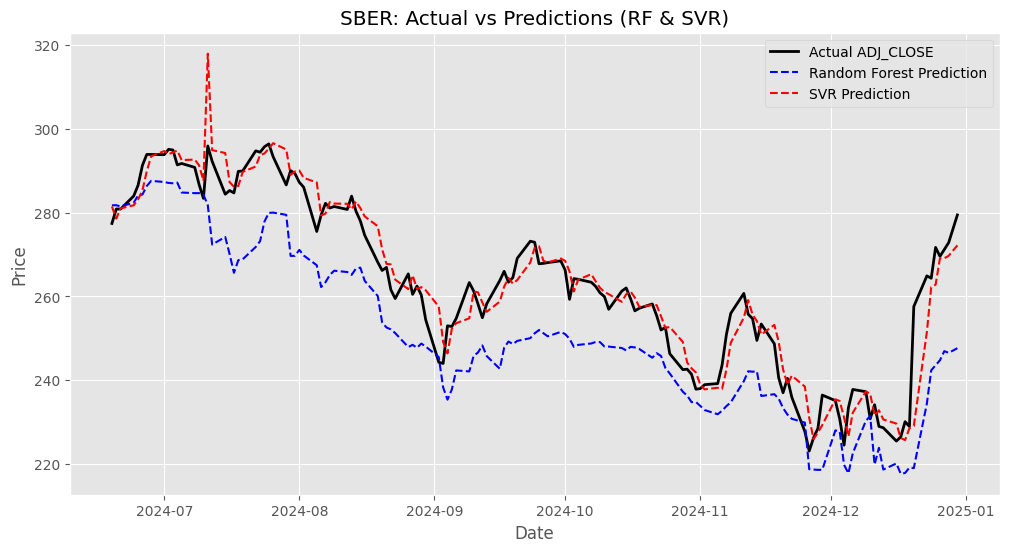

In [28]:
ticker = 'SBER'
sber = ml_data[ticker].copy()

sber_train_val = sber.loc[train_start:val_end]
sber_test = sber.loc[test_start:test_end].copy()

X_train_val, y_train_val = sber_train_val[features], sber_train_val[target]
X_test, y_test = sber_test[features], sber_test[target]

sber_rf_model = RandomForestRegressor(**best_params_RF[ticker], random_state=42)
sber_rf_model.fit(X_train_val, y_train_val)

sber_svr_model = make_pipeline(StandardScaler(), SVR(**best_params_SVR[ticker]))
sber_svr_model.fit(X_train_val, y_train_val)

sber_test["y_pred_RF"] = sber_rf_model.predict(X_test)
sber_test["y_pred_SVR"] = sber_svr_model.predict(X_test)

plt.figure(figsize=(12, 6))

plt.plot(sber_test.index, sber_test["ADJ_CLOSE"], label="Actual ADJ_CLOSE", color="black", linewidth=2)
plt.plot(sber_test.index, sber_test["y_pred_RF"], label="Random Forest Prediction", color="blue", linestyle="dashed")
plt.plot(sber_test.index, sber_test["y_pred_SVR"], label="SVR Prediction", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("SBER: Actual vs Predictions (RF & SVR)")
plt.legend()
plt.grid(True)
plt.show()


### **Feature importance**

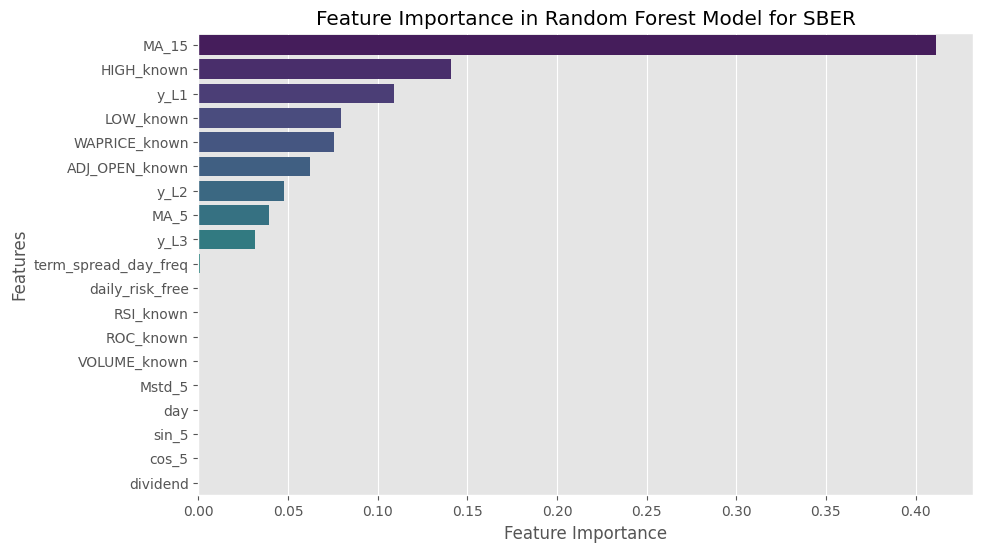

PermutationExplainer explainer: 141it [01:39,  1.41it/s]


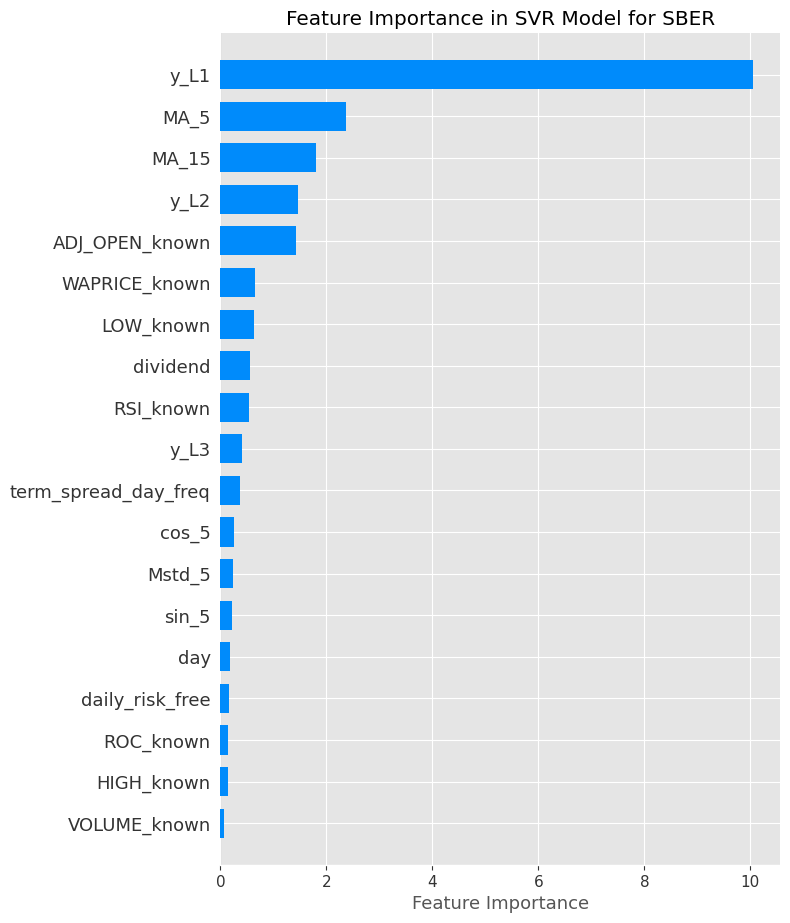

In [29]:
feature_importance_RF = pd.Series(sber_rf_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_RF, y=feature_importance_RF.index, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model for SBER")
plt.show()

explainer = shap.Explainer(sber_svr_model.predict, X_test)
shap_values = explainer(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in SVR Model for SBER")
plt.show()


# **Results**


## **Total returns**




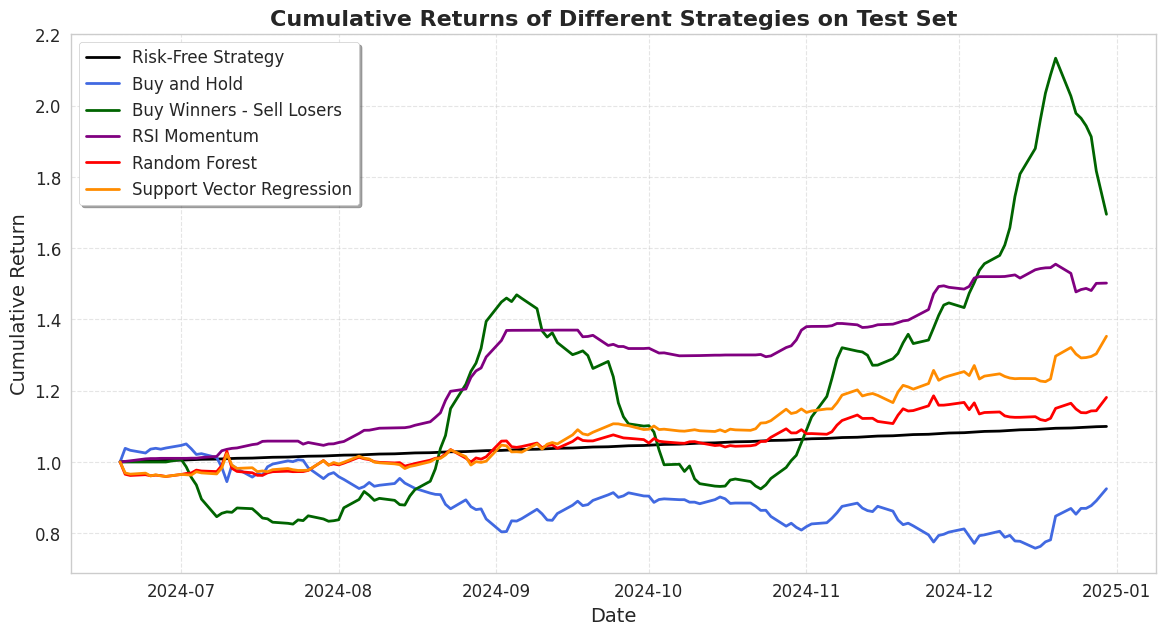

In [30]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

plt.plot(risk_free.loc[test_start:test_end].index, risk_free.loc[test_start:test_end,"total_returns"], label="Risk-Free Strategy", linestyle="solid", color="black", linewidth=2)
plt.plot(out_of_sample_bah['total_returns'].index, out_of_sample_bah["total_returns"], label="Buy and Hold", linestyle="solid", color="royalblue", linewidth=2)
plt.plot(out_of_sample_bwsl['total_returns'].index, out_of_sample_bwsl["total_returns"], label="Buy Winners - Sell Losers", linestyle="solid", color="darkgreen", linewidth=2)
plt.plot(out_of_sample_rsi['total_returns'].index, out_of_sample_rsi["total_returns"], label="RSI Momentum", linestyle="solid", color="purple", linewidth=2)
plt.plot(total_daily_returns_RF.index, total_daily_returns_RF["total_returns"], label="Random Forest", linestyle="solid", color="red", linewidth=2)
plt.plot(total_daily_returns_SVR.index, total_daily_returns_SVR["total_returns"], label="Support Vector Regression", linestyle="solid", color="darkorange", linewidth=2)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Return", fontsize=14)
plt.title("Cumulative Returns of Different Strategies on Test Set", fontsize=16, fontweight="bold")
plt.legend(fontsize=12, loc="upper left", frameon=True, shadow=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


## **Maximum Drawdown (MDD) and Maximum Drawdown Duration (MDDD) of the strategies**

*  MDD is the difference between the **global maximum** of the performance curve with the **global minimum**.

*  MDDD is the longest time it takes to **recover losses**.

These metrics assess **downside risk**.

In [31]:
def calculate_mdd_and_duration(cumulative_returns):
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    drawdown_periods = (drawdown < 0).astype(int)
    drawdown_durations = drawdown_periods.groupby((drawdown_periods != drawdown_periods.shift()).cumsum()).cumsum()
    max_drawdown_duration = drawdown_durations.max()

    return max_drawdown, max_drawdown_duration

mdd_risk_free, mddd_risk_free = calculate_mdd_and_duration(risk_free["total_returns"])
mdd_bah, mddd_bah = calculate_mdd_and_duration(out_of_sample_bah["total_returns"])
mdd_bwsl, mddd_bwsl = calculate_mdd_and_duration(out_of_sample_bwsl["total_returns"])
mdd_rsi, mddd_rsi = calculate_mdd_and_duration(out_of_sample_rsi["total_returns"])
mdd_rf, mddd_rf = calculate_mdd_and_duration(total_daily_returns_RF["total_returns"])
mdd_svr, mddd_svr = calculate_mdd_and_duration(total_daily_returns_SVR["total_returns"])

mddd_risk_free = pd.Timedelta(days=mddd_risk_free).days
mddd_bah = pd.Timedelta(days=mddd_bah).days
mddd_bwsl = pd.Timedelta(days=mddd_bwsl).days
mddd_rsi = pd.Timedelta(days=mddd_rsi).days
mddd_rf = pd.Timedelta(days=mddd_rf).days
mddd_svr = pd.Timedelta(days=mddd_svr).days

print(f"Risk-Free Strategy: MDD = {mdd_risk_free:.2%}, MDDD = {mddd_risk_free} days")
print(f"Buy and Hold: MDD = {mdd_bah:.2%}, MDDD = {mddd_bah} days")
print(f"Buy Winners - Sell Losers: MDD = {mdd_bwsl:.2%}, MDDD = {mddd_bwsl} days")
print(f"RSI Momentum: MDD = {mdd_rsi:.2%}, MDDD = {mddd_rsi} days")
print(f"Random Forest: MDD = {mdd_rf:.2%}, MDDD = {mddd_rf} days")
print(f"Support Vector Regression: MDD = {mdd_svr:.2%}, MDDD = {mddd_svr} days")


Risk-Free Strategy: MDD = 0.00%, MDDD = 0 days
Buy and Hold: MDD = -27.86%, MDDD = 130 days
Buy Winners - Sell Losers: MDD = -37.08%, MDDD = 62 days
RSI Momentum: MDD = -5.46%, MDDD = 32 days
Random Forest: MDD = -6.55%, MDDD = 31 days
Support Vector Regression: MDD = -4.97%, MDDD = 31 days


## **Out-of-sample Sharpe Ratios**

Only **RSI Momentum** and **SVR** show statistically significant positive returns at a 5% significance level.

In [32]:
data = {
    "Daily Sharpe": [
        out_of_sample_bah["sharpe_ratio"],
        out_of_sample_bwsl["sharpe_ratio"],
        out_of_sample_rsi["sharpe_ratio"],
        sharpe_RF,
        sharpe_SVR
    ],
    "Annualized Sharpe": [
        out_of_sample_bah["sharpe_ratio"] * np.sqrt(252),
        out_of_sample_bwsl["sharpe_ratio"] * np.sqrt(252),
        out_of_sample_rsi["sharpe_ratio"] * np.sqrt(252),
        sharpe_RF * np.sqrt(252),
        sharpe_SVR * np.sqrt(252)
    ],
    "t-Statistic": [
        out_of_sample_bah["t_statistic"],
        out_of_sample_bwsl["t_statistic"],
        out_of_sample_rsi["t_statistic"],
        t_statistic_RF,
        t_statistic_SVR
    ]
}

strategies = [
    "Buy and Hold",
    "Buy Winners - Sell Losers",
    "RSI Momentum",
    "Random Forest",
    "Support Vector Regression"
]

sharpe_df = pd.DataFrame(data, index=strategies)

sharpe_df = sharpe_df.round({"Daily Sharpe": 4, "Annualized Sharpe": 4, "t-Statistic": 2}).sort_values(by="Daily Sharpe", ascending=False)

sharpe_df

,Daily Sharpe,Annualized Sharpe,t-Statistic
RSI Momentum,0.2594,4.1183,3.99
Buy Winners - Sell Losers,0.1390,2.2059,1.89
Support Vector Regression,0.1206,1.9137,2.05
Random Forest,0.0493,0.7826,1.27
Buy and Hold,-0.0633,-1.0053,-0.32


# **Conclusion**

The study demonstrates that while traditional momentum strategies such as **Buy Winners - Sell** Losers perform decently, **RSI-based momentum trading** and **machine learning models** (particularly **SVR**) provide superior risk-adjusted returns. The **RSI Momentum Strategy** outperforms others in both Sharpe Ratio and maximum drawdown. Further research could explore deep learning techniques or reinforcement learning for improved stock market predictions.